# Prelim

In [1]:
import re
import pandas as pd
import os
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx

def load_data(n_nodes, seed, version_path):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'{version_path}/W/W_{seed}_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'{version_path}/X/X_1.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_est = W['W_est']
    W = W['W_est'][:, :n_nodes]
    Z = np.abs(W[:n_nodes]) - np.abs(W[n_nodes:])
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return X, B_true, W_est, W_true

def get_block(data, n_nodes=20, index=11, extract=None):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def get_Z(data, n_nodes=20, left=11, right=21, extract=None):
    left_block = get_block(data, n_nodes, left)
    right_block = get_block(data, n_nodes, right)
    res = np.abs(left_block) - np.abs(right_block)
    
    return res

def get_cutoff(Z11_21):
    fdr_est_last = 1.
    t_last = np.inf
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z11_21)))))
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z11_21 <= -t).sum()) / np.max((1, (Z11_21 >= t).sum()))
        
        if fdr_est <= 0.2:
            t_last = t
            fdr_est_last = fdr_est
    return t_last

def draw_strip(n_nodes, ax, version=None, s0=4, only_null=True):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    Z11_21 = get_Z(W_est, n_nodes)
    mask_pos = (Z11_21 > 0.) & (~B_true)
    mask_neg = (Z11_21 < 0.) & (~B_true)
    mask_pos_all = (Z11_21 > 0.)
    mask_neg_all = (Z11_21 < 0.)

    if only_null:
        sns.stripplot([np.abs(Z11_21[mask_pos]), np.abs(Z11_21[mask_neg])], ax=ax)
    else:
        true_label_pos = B_true[mask_pos_all]
        true_label_neg = B_true[mask_neg_all]
        
        data_dict = {
            "|Z|": np.concatenate([
                np.abs(Z11_21[mask_pos_all]),
                np.abs(Z11_21[mask_neg_all])
            ]),
            "category": \
                ['Z > 0'] * mask_pos_all.sum() + \
                ['Z < 0'] * mask_neg_all.sum()
            ,
            "edge_label": np.concatenate([
                true_label_pos,
                true_label_neg
            ])  
        }
        data_dict = pd.DataFrame(data_dict)
        
        # sns.stripplot([np.abs(Z11_21[mask_pos_all]), np.abs(Z11_21[mask_pos_neg])], ax=ax)
        sns.stripplot(data_dict, x="category", y='|Z|', hue="edge_label", ax=ax, alpha=0.7)
    cutoff = get_cutoff(Z11_21)
    ax.axhline(y=cutoff, color='red', linestyle='--')
    ax.set_xticks([0, 1], ["Z > 0", "Z < 0"])
    if only_null:
        ax.set_ylabel("|Z| of null edges")
    else:
        ax.set_ylabel("|Z| of all edges")
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def draw_ecdf(n_nodes, ax, log=False, version=None, s0=4):
    if version is None:
        version = f"v34/v{n_nodes}"
    B_true, W_est = load_data(n_nodes, 1, version)
    W11, W21 = get_block(W_est, n_nodes, index=11), get_block(W_est, n_nodes, index=21)
    if log:
        sns.ecdfplot(np.log(np.abs(W11[~B_true])+1e-8).flatten(), ax=ax, label="log|W11| null")
        sns.ecdfplot(np.log(np.abs(W21[~B_true])+1e-8).flatten(), ax=ax, label="log|W21| null")
    else:
        sns.ecdfplot(np.abs(W11[~B_true]).flatten(), ax=ax, label="|W11| null")
        sns.ecdfplot(np.abs(W21[~B_true]).flatten(), ax=ax, label="|W21| null")
    ax.set_ylim([0., 1.1])
    ax.set_title(f"{n_nodes} nodes | {s0 * n_nodes} edges | seed= 1")

def z0_vs_deg(Z11_21, B_true, out_deg, in_deg, ax, z_option, src, use_out_deg, op='mean'):
    # null edges of Z > 0
    if z_option == ">":
        mask = (Z11_21 > 0.) & (~B_true)
        z_str = 'Z > 0'
    elif z_option == "<":
        mask = (Z11_21 < 0.) & (~B_true)
        z_str = 'Z < 0'
        Z11_21 = np.abs(Z11_21)
    elif z_option == "all":
        mask = (~B_true)
        z_str = 'Z'
    elif z_option == "abs":
        mask = (~B_true)
        z_str = '|Z|'
    else:
        raise NotImplementedError(f"{z_option}")
    
    # mean over all in edges for each source node
    if z_option == "abs":
        Z11_21 = np.abs(Z11_21)
    if src:
        if op == 'mean':
            Z11_21 = (Z11_21 * mask.astype(float)).sum(axis=1) / mask.astype(float).sum(axis=1)
        elif op == 'max':
            Z11_21 = (Z11_21 * mask.astype(float)).max(axis=1)
        else:
            raise NotImplementedError(f"{op}")
        src_str = "source"
    else:
        if op == 'mean':
            Z11_21 = (Z11_21 * mask.astype(float)).sum(axis=0) / mask.astype(float).sum(axis=0)
        elif op == 'max':
            Z11_21 = (Z11_21 * mask.astype(float)).max(axis=0)
        else:
            raise NotImplementedError(f"{op}")
        src_str = "destination"
    
    deg2n = {}
    if use_out_deg:
        deg_list = out_deg
        deg_str = "out-degree"
    else:
        deg_list = in_deg
        deg_str = "in-degree"
    deg_uni = np.unique(deg_list)
    
    for deg in deg_uni:
        _mask = np.where(deg_list == deg)[0]
        if op == 'mean':
            deg2n[deg] = Z11_21[_mask].mean()
        elif op == 'max':
            deg2n[deg] = Z11_21[_mask].max()
        else:
            raise NotImplementedError(f"{op}")
        
    ax = sns.lineplot(x=deg2n.keys(), y=deg2n.values(), marker='o', ax=ax)
    ax.set_title(f'{z_str} of null edges vs {deg_str} of {src_str} nodes')

def z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src, use_out_deg, use_strip=False):
    
    if src:
        src_str = "source"
    else:
        src_str = "destination"
    
    
    if use_out_deg:
        deg_list = out_deg
        deg_str = "out-degree"
    else:
        deg_list = in_deg
        deg_str = "in-degree"
    deg_uni = np.unique(deg_list)

    data_dict = {
        "deg": [],
        "Z": [],
        "label": []
    }
    
    for deg in deg_uni:
        _n_mask = np.where(deg_list == deg)[0]
        n_mask = np.full(len(deg_list), fill_value=False)
        n_mask[_n_mask] = True
        """ true edges """
        _mask = B_true.copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["true edges"] * len(_data))

        """ false edges """
        _mask = (~B_true).copy()
        if src:
            _mask[~n_mask, :] = False
            _data = Z11_21[_mask].flatten().tolist()
        else:
            _mask[:, ~n_mask] = False
            _data = Z11_21[_mask].flatten().tolist()
            
        data_dict['Z'].extend(_data)
        data_dict['deg'].extend([deg] * len(_data))
        data_dict['label'].extend(["null edges"] * len(_data))
        
    df = pd.DataFrame(data_dict)
    # sns.boxplot(df, x='deg', y='Z', hue='label', ax=ax[0])
    # if use_strip:
    #     sns.stripplot(df, x='deg', y='Z', hue='label', ax=ax[0], alpha=0.7)
    # sns.boxplot(df.loc[df['label'] == 'null edges', :], x='deg', y='Z', hue='label', ax=ax[1])
    # if use_strip:
    #     sns.stripplot(df.loc[df['label'] == 'null edges', :], x='deg', y='Z', hue='label', ax=ax[1], alpha=0.7)
    # ax[0].set_title(f'Z vs {deg_str} of {src_str} nodes | {len(Z11_21)} nodes | {4 * len(Z11_21)} edges | seed 1')
    return df
    
def z0_vs_deg_combine(Z11_21, B_true, out_deg, in_deg, ax, z_option, src, comb, op='mean'):
    # null edges of Z > 0
    if z_option == ">":
        mask = (Z11_21 > 0.) & (~B_true)
        z_str = 'Z > 0'
    elif z_option == "<":
        mask = (Z11_21 < 0.) & (~B_true)
        z_str = 'Z < 0'
        Z11_21 = np.abs(Z11_21)
    elif z_option == "all":
        mask = (~B_true)
        z_str = 'Z'
    elif z_option == "abs":
        mask = (~B_true)
        z_str = '|Z|'
    else:
        raise NotImplementedError(f"{z_option}")
    
    # mean over all in edges for each source node
    if z_option == "abs":
        Z11_21 = np.abs(Z11_21)
    if src:
        if op == 'mean':
            Z11_21 = (Z11_21 * mask.astype(float)).sum(axis=1) / mask.astype(float).sum(axis=1)
        elif op == 'max':
            Z11_21 = (Z11_21 * mask.astype(float)).max(axis=1)
        else:
            raise NotImplementedError(f"{op}")
        src_str = "source"
    else:
        if op == 'mean':
            Z11_21 = (Z11_21 * mask.astype(float)).sum(axis=0) / mask.astype(float).sum(axis=0)
        elif op == 'max':
            Z11_21 = (Z11_21 * mask.astype(float)).max(axis=0)
        else:
            raise NotImplementedError(f"{op}")
        src_str = "destination"
    
    deg2n = {}
    if comb == 'out-in':
        deg_list = out_deg - in_deg
    elif comb == 'in-out':
        deg_list = in_deg - out_deg
    elif comb == 'out+in':
        deg_list = out_deg + in_deg
    elif comb == 'out*in':
        deg_list = out_deg * in_deg
    elif comb == 'out/in':
        deg_list = out_deg / (in_deg+1)
    elif comb == 'in/out':
        deg_list = in_deg / (out_deg+1)
    deg_uni = np.unique(deg_list)
    
    for deg in deg_uni:
        _mask = np.where(deg_list == deg)[0]
        if op == 'mean':
            deg2n[deg] = Z11_21[_mask].mean()
        elif op == 'max':
            deg2n[deg] = Z11_21[_mask].max()
        else:
            raise NotImplementedError(f"{op}")
        
    ax = sns.lineplot(x=deg2n.keys(), y=deg2n.values(), marker='o', ax=ax)
    ax.set_title(f'{z_str} of null edges vs {comb} deg of {src_str} nodes')

# exp 0

In [53]:
def get_res(n_nodes, alpha=1.):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    data_dir = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v40/0'
    data_name = f'W_conv_{n_nodes}_{n_nodes * 4}_1.pkl'
    with open(os.path.join(data_dir, data_name), 'rb') as f:
        W_conv = pickle.load(f)
    
    data_dir_ori = '/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v39'
    data_name_ori = f'W_{n_nodes}_{n_nodes * 4}_1.pkl'
    with open(os.path.join(data_dir_ori, data_name_ori), 'rb') as f:
        W = pickle.load(f)
    
    X, B_true, W_est, W_true = load_data(n_nodes, 1, f"v34/v{n_nodes}")
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)
    
    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)
    
    data_dict = {
        'W_conv_all': W_conv.flatten(),
        'W_conv_true': W_conv[B_true].flatten(),
        'W_conv_null': W_conv[~B_true].flatten(),
        'W_all': W.flatten(),
        'W_true': W[B_true].flatten(),
        'W_null': W[~B_true].flatten(),
        '(|W_conv| - |W|) all': (np.abs(W_conv) - np.abs(W)).flatten(),
        '(|W_conv| - |W|) true': (np.abs(W_conv) - np.abs(W))[B_true].flatten(),
        '(|W_conv| - |W|) null': (np.abs(W_conv) - np.abs(W))[~B_true].flatten()
    }
    ax = sns.stripplot(data_dict, ax=ax, alpha=alpha)
    ax.set_ylabel("values")
    ax.set_title(f"{n_nodes} nodes | {4 * n_nodes} edges | seed=1 | X_conv = X * W_true | W_true = DAGMA(X_conv)")
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xticks(rotation=30)

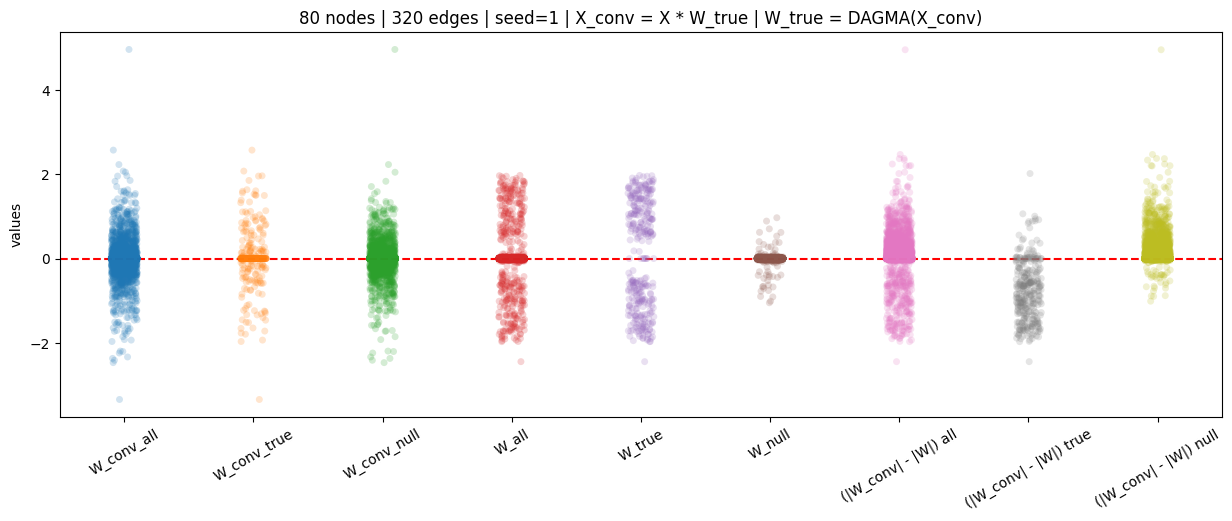

In [63]:
get_res(80, 0.2)

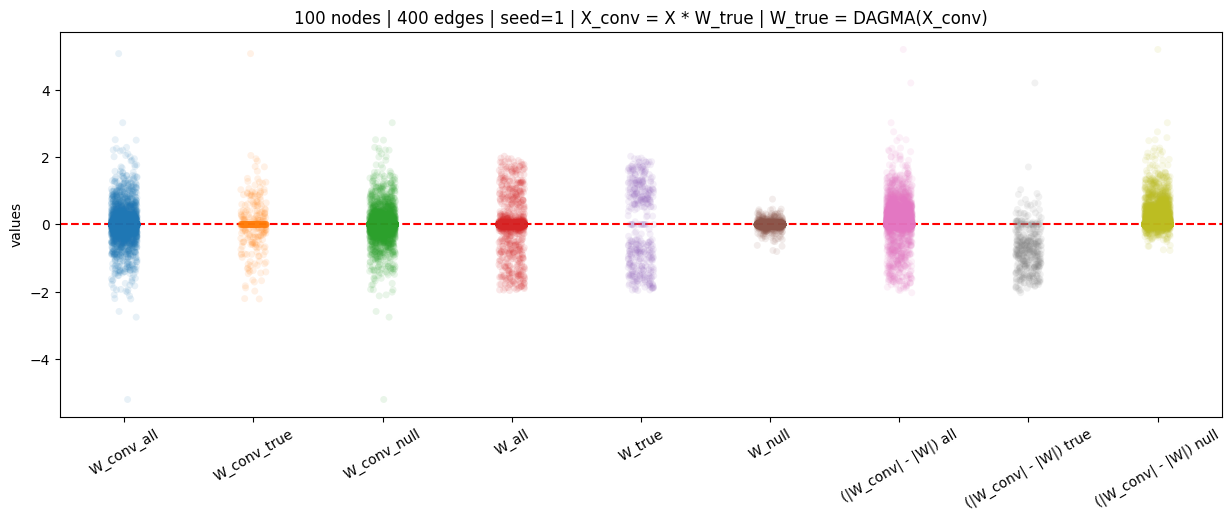

In [61]:
get_res(100, 0.1)